![image](../docs/img/cern-csc-vis-header.png)

# Interactive Visual Exploration with Altair

Static visualizations are good, but they definitely have their limitations. It's definitely cumbersome to figure out what the outlier is in a static visualization.

There have been a number of interesting developments in recent years, in particular Bokeh, plot.ly, and most recently Altair.

Altair is more declarative, by that I mean that the mapping from data to visual is more natural. There is a specific grammar for the composition of charts, and with this you can go far quickly. Note, Altair is a Python library that is in essence a builder for Vega/Vega-Lite JSON specifications.

Visualizations are composed of marks, mapping data to lines, shapes, size, and opacity.


Note, exercises are marked in terms of difficulty by basic, advanced, or optional. These have been colour coded as follows:

<p style="background: #81ecec; padding: 10px; color: #2d3436"><strong>Basic</strong>: Basic will achievable by all in the class. This usually involves running the code you've seen before with your own parameters, or at most, checking the Matplotlib or Seaborn documentation on how to use some API.</p>

<p style="background: #fab1a0; padding: 10px; color: #2d3436"><strong>Advanced</strong>: This will be more appropriate for those who already have familiarity with the tools at hand, but which wil (hopefully) introduce some topics you have not seen before.</p>

<p style="background: #ffeaa7; padding: 10px; color: #2d3436"><strong>Optional</strong>: Optional allows you to express your inner data scientist and to show everyone how awesome you are in the use of Pandas, Matplotlib, and Seaborn :)</p>


In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import altair as alt
import pandas as pd

In [2]:
# alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
fifa = pd.read_csv('../data/fifa_player_data.csv.gz')

In [4]:
mapping = {'RCB': 'DEF', 'LCB': 'DEF', 'CB': 'DEF',
           'LB': 'DEF', 'RB': 'DEF', 
           'LWB': 'DEF', 'RWB': 'DEF',
           'CDM': 'MID', 'RM': 'MID',
           'LCM': 'MID', 'RCM': 'MID', 'LM': 'MID', 'CAM': 'MID',
           'LDM': 'MID', 'RDM': 'MID',
           'LAM': 'MID', 'RAM': 'MID',
           'CM': 'MID', 'LW': 'MID', 'RW': 'MID',
           'LS': 'ST', 'RS': 'ST', 'RF': 'ST', 'LF': 'ST', 'CF': 'ST'
          }
fifa['GeneralPosition'] = fifa.Position.apply(lambda x: mapping[x] if x in mapping else x )

At present, our wages, release clause, and player valuation are strings. But of course, it would be great if we could use them.

In [6]:
import re
fifa['ValueNorm'] = fifa.Value.apply(lambda x: float(re.sub('M|K', '', x[1:])) * (1000000 if x.endswith('M') else 1000))

fifa['ReleaseClauseNorm'] = fifa['Release Clause'].fillna('€0M').apply(lambda x: float(re.sub('M|K', '', str(x)[1:])) * (1000000 if x.endswith('M') else 1000))

fifa['WageNorm'] = fifa['Wage'].apply(lambda x: float(re.sub('M|K', '', str(x)[1:])) * (1000000 if x.endswith('M') else 1000))


In [9]:
# Now we remove the players with no position.
fifa = fifa[~fifa.GeneralPosition.isna()]

In [10]:
# Altair works rather differently from the Matplotlib etc. since it is acting as a proxy for a JSON file that will be rendered via Vega. We need to keep this JSON file relatively light so as not to crash Jupyter.
sample = fifa.sample(3000)

## Basics of Altair

Creating a chart in Altair is pretty simple.

Let's take this task:

> **We want to view the distribution of player Accelerations, but each mark needs to represent a player**

Since it's just one line, and on that line we want to plot each player's acceleration, using some visual mark (e.g. circle, line)

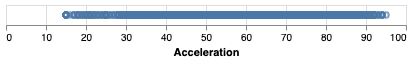

In [11]:
alt.Chart(sample).mark_point().encode(
    x='Acceleration',
)

### A segway on performance

Since we're saving this file to JSON, check the size of that JSON file as it stands now. You'll see that this one file to create one simple visualization is over 4MB for our sample!

Let's fix this, so things load quicker. We only need the fields we're visualizing, not everything.

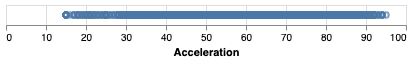

In [12]:
alt.Chart(sample[['Acceleration']]).mark_point().encode(
    x='Acceleration',
)

Now our file is around 66kb.

We can improve this by changing the opacity of the points so we can get a better idea of the distribution.

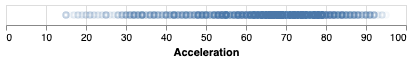

In [13]:
alt.Chart(sample[['Acceleration']]).mark_point(opacity=0.05).encode(
    x='Acceleration',
)

The point can be changed to a tick (line). 

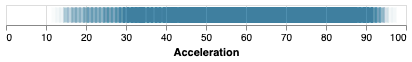

In [14]:
alt.Chart(fifa[['Acceleration']]).mark_tick(
    opacity=0.03, 
    thickness=5).encode(
    x='Acceleration',
)

Or a filled circle very easily.

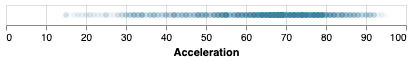

In [15]:
alt.Chart(sample[['Acceleration']]).mark_circle(opacity=0.03).encode(
    x='Acceleration',
)

Our users have now come back with the following task. 

> **We want to view the distribution of player Accelerations for each position**


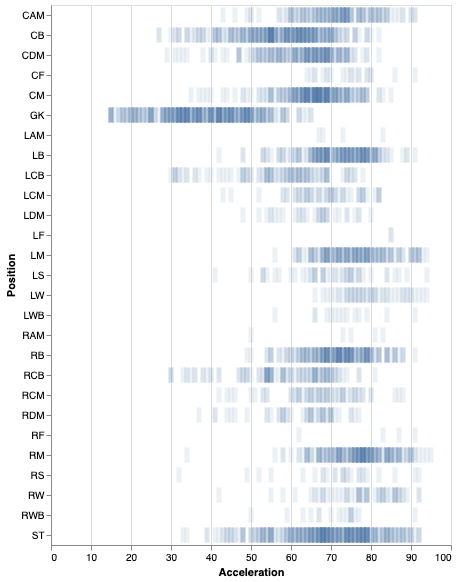

In [16]:
alt.Chart(sample[['Acceleration', 'Position']]).mark_tick(opacity=0.1, thickness=5).encode(
    x='Acceleration',
    y='Position'
)

## Adding Interactivity

### Zooming

In [ ]:
alt.Chart(sample[['Acceleration', 'Position']]).mark_tick(opacity=0.1, thickness=5).encode(
    x='Acceleration',
    y='Position'
).interactive()

### Tooltips

In [ ]:
alt.Chart(sample[['Acceleration', 'Position', 'Name', 'Nationality']]).mark_tick(opacity=0.1, thickness=5).encode(
    x='Acceleration',
    y='Position',
    tooltip=['Name', 'Nationality']
)

# Customising Plots

Similar to what we did in Part 2, we can change how the chart looks in terms or colours, usage of axes, grids, etc.

## Removing Grid Lines

In [ ]:
alt.Chart(sample[['Acceleration', 'Position', 'Name', 'Nationality']]).mark_tick(opacity=0.1, thickness=5).encode(
    x='Acceleration',
    y='Position',
    tooltip=['Name', 'Nationality']
).configure_axis(
    grid=False,
    domain=False,
).configure_view(
    strokeWidth=0
)

In this example, the removal of the lines etc. makes the plot much cleaner, bringing attention to the data rather than that which surrounds it.

## Theming

We often need to change the style to reflect requirements from experiments, or for the publication venue, conference theme etc. With Altair this is pretty easy!

E.g., let's take the Financial Times style of graphic like the one shown here from this [tweet](https://twitter.com/mihirssharma/status/536728204111654912).

![image](https://pbs.twimg.com/media/B3LTKfEIEAEkrUr.png)

In Altair every displayed item can be configured, a nice tutorial is available. We are not of course able to cover everything here, but a good tutorial can be found [here](https://towardsdatascience.com/consistently-beautiful-visualizations-with-altair-themes-c7f9f889602).

We'll create a basic replication of the style here with a minimal amount of code :)

In [ ]:
alt.Chart(fifa[['Acceleration', 'Position', 'Name', 'Nationality']]).mark_tick(opacity=0.1, thickness=5, color='#EAA8A7').encode(
    x='Acceleration',
    y='Position',
    tooltip=['Name', 'Nationality']
).configure_axis(
    grid=False,
    domain=False,
    labelFont='Lato',
    labelColor='#555555'
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    fontSize=22,
    font='Lato',
    fontWeight='normal',
    color='#555555'
).properties(
    title='Acceleration by Position',
    background='#FFF1E0',
    padding= 20
)

There is also the possibility to make this a theme that can be configured externally then used in all subsequent plots. Doing so is explained in this [post](https://towardsdatascience.com/consistently-beautiful-visualizations-with-altair-themes-c7f9f889602).

In [ ]:
def financial_times_theme():
    # Typography
    font = "Lato"
    labelFont = "Lato" 
    sourceFont = "Lato"
    # Axes
    axisColor = "#555555"
    gridColor = "#DEDDDD"
    
    markColor = '#990F3D'
    # Colors
    main_palette = ["#990F3D", 
                    "#0F5499",
                    "#0D7680", 
                    "#593380", 
                    "#FF8833", 
                    "#FFEC1A", 
                    "#000000", 
                   ]
    
    sequential_palette = ["#cfe8f3", 
                          "#e0adb3", 
                          "#cc8091", 
                          "#b8536f", 
                          "#a3264e", 
                          "#990f3d", 
                         ]
    
    return  {
        "width": 600, # from the guide
        "height": 400, # not in the guide
        "background": "#FFF1E0",
        "color": "#555555",
        "grid": False,
        "config": {
            "title": {
                "fontSize": 18,
                "font": font,
                "anchor": "start", # equivalent of left-aligned.
                "color": "#555555"
            },
            "axisX": {
                "domain": False,
                "grid": False,
                "labelFont": labelFont,
                "labelFontSize": 12,
                "labelAngle": 0, 
                "labelColor": "#555555",
                "tickColor": axisColor,
                "tickSize": 5, # default, including it just to show you can change it
                "titleFont": font,
                "titleFontSize": 12,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "X Axis Title (units)", 
            },
            "axisY": {
                "domain": False,
                "grid": False,
                "labelFont": labelFont,
                "labelFontSize": 12,
                "labelColor": "#555555",
                "labelAngle": 0, 
                "ticks": False, # even if you don't have a "domain" you need to turn these off.
                "titleFont": font,
                "titleFontSize": 12,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "Y Axis Title (units)", 
                # titles are by default vertical left of axis so we need to hack this 
                "titleAngle": 0, # horizontal
                "titleY": -10, # move it up
                "titleX": 18, # move it to the right so it aligns with the labels 
            },
            
            "range": {
                "category": main_palette,
                "diverging": sequential_palette,
            },
            
            "view": {
                "stroke": "transparent"
            },
            
            "tick":{
                "color": markColor
            },
            
            "point":{
                "color": markColor
            },
            
            "bar":{
                "color": markColor
            },
            
            "line":{
                "stroke": markColor
            }
    }
    }

In [ ]:
alt.themes.register("financial_times_theme", financial_times_theme)
alt.themes.enable("financial_times_theme")

In [ ]:
alt.Chart(sample[['Acceleration']]).mark_tick(
    opacity=0.03, 
    thickness=5).encode(
    x=alt.X('Acceleration', title='Acceleration'),
).properties(height=40, title='Distribution of Player Acceleration')

In [ ]:
alt.themes.enable("default")

# Visualizing Distributions

## Histograms

### One Group

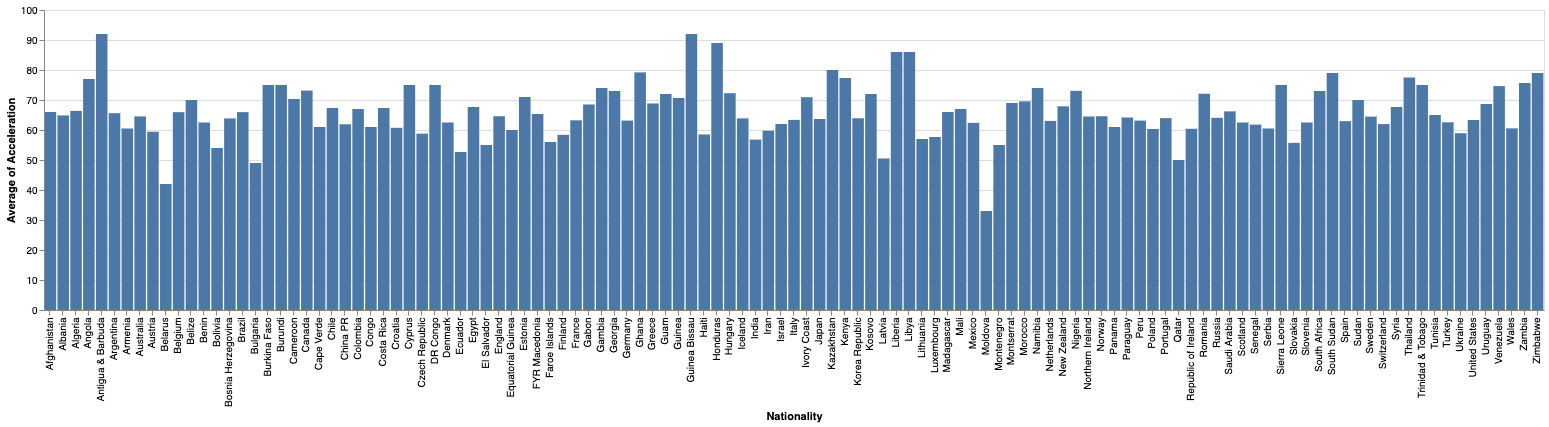

In [17]:
alt.Chart(sample[['Acceleration', 'Nationality']]).mark_bar().encode(
    x='Nationality',
    y='average(Acceleration)'
).properties(width=1500)

<p style="background: #81ecec; padding: 10px; color: #2d3436"><strong>BASIC EXERCISE</strong> | Which country has the highest average acceleration?</p>

Guinea Bissau and Antigua & Barbuda

### Sorting Values

The previous exercise was difficult, because the choices we've made (or haven't thought about) have made it harder for users to compare values. But, as shown in our lectures, if you can sort, it'll make comparison easier. How does it look if we sort by the Average Acceleration? And how does it speed up the exercise you had before?

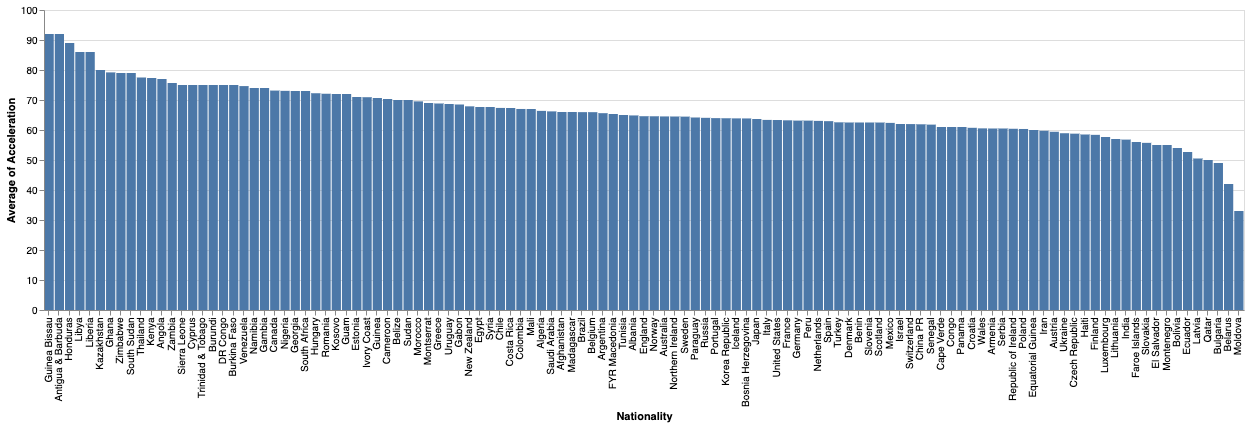

In [20]:
alt.Chart(sample[['Acceleration', 'Nationality']]).mark_bar().encode(
    x=alt.X('Nationality', sort=alt.EncodingSortField(field='Acceleration', op='average', order='descending')),
    y='average(Acceleration)'
).properties(width=1200)

## Comparing Distributions

### Superimposed

In [ ]:
alt.Chart(sample[['GeneralPosition', 'Reactions']]).mark_area(
    opacity=0.5,
    interpolate='step',
).encode(
    alt.X('Reactions', bin=alt.Bin(maxbins=20)),
    alt.Y('count()', stack=None, axis=alt.Axis(title='Number of Players')),
    color='GeneralPosition',
    tooltip=['GeneralPosition']
)

### Juxtaposed

In [ ]:
alt.Chart(sample[['GeneralPosition', 'ShortPassing']]).mark_area(
    interpolate='step'
).encode(
    alt.X('ShortPassing', bin=alt.Bin(maxbins=25)),
    alt.Y('count()', stack=None, axis=alt.Axis(title='Number of Players')),
    alt.Color(
        'GeneralPosition',
    ),
    tooltip=['GeneralPosition']
).properties(height=200, width=150).facet(facet='GeneralPosition', columns=2)

In [ ]:
chart1 = alt.Chart().mark_boxplot().encode(
    x='GeneralPosition',
    y='ShortPassing',
    color='GeneralPosition',
    tooltip=['Name', 'Position', 'Nationality']
).interactive().properties(width=150)

chart2 = alt.Chart().mark_boxplot().encode(
    x='GeneralPosition',
    y='Finishing',
    color='GeneralPosition',
    tooltip=['Name', 'Position', 'Nationality']
).interactive().properties(width=150)

alt.hconcat(chart1, chart2, data=sample[['GeneralPosition', 'ShortPassing', 'Finishing', 'Name', 'Position', 'Nationality']])

It would be of course better to use something like a box plot to show the distributions instead.

Our users have now come back with the following task. 

> **We want to view the distribution of player Accelerations for each position broken down by Nationality**


In [ ]:
alt.Chart(sample[['Acceleration', 'Nationality']]).mark_boxplot().encode(
    x='Acceleration',
    y='Nationality',
).properties(height=2000)

In [ ]:
alt.Chart(sample[['Acceleration', 'Nationality', 'GeneralPosition', 'Name']]).mark_circle().encode(
    x='Acceleration',
    y=alt.Y('Nationality', sort=alt.EncodingSortField(field='Acceleration', op='max', order='descending')),
    color='GeneralPosition',
    tooltip=['Name']
).properties(height=1200).configure_axis(domain=False, grid=False).configure_axisX(grid=True)

# Visualizing Correlations

## Scatter Charts

In [ ]:
alt.Chart(sample[['Acceleration', 'SprintSpeed', 'GeneralPosition', 'Name', 'Nationality', 'Position']]).mark_circle().encode(
    x='Acceleration',
    y='SprintSpeed',
    color='GeneralPosition',
    tooltip=['Name', 'Position', 'Nationality', 'Acceleration', 'SprintSpeed']
).interactive()

## Heatmaps

In [ ]:
alt.Chart(fifa.corr().reset_index().melt(id_vars='index')).mark_rect().encode(
    x='index',
    y='variable',
    color=alt.Color('value', scale=alt.Scale(scheme='blueorange', zero=True)),
    tooltip=['index', 'variable', 'value']
).properties(width=600, height=600)

# Repeating Charts

In [ ]:
import altair as alt

brush = alt.selection_interval()

alt.Chart(fifa.query('Nationality=="Romania"')).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
     color=alt.condition(brush, 'GeneralPosition:N', alt.value('lightgray')),
        tooltip=['Name', 'GeneralPosition']
).properties(
    width=200,
    height=200
).add_selection(
    brush
).repeat(
    row=['Acceleration', 'SprintSpeed'],
    column=['Finishing', 'Strength']
).configure_axisX(labelAngle=0).properties(title="Romanian Players")

# Facets

Sometimes we also want to create many small juxtaposed plots to show distributions of values split by some feature, such as Nationality.

Again, in Altair, this is really straightforward.

In [ ]:
alt.Chart(sample[['Acceleration', 'GeneralPosition', 'Nationality']]).mark_boxplot().encode(
    x='Acceleration',
    y='GeneralPosition',
    color='GeneralPosition'
).properties(width=100).facet(facet='Nationality', columns=7).properties(title='Acceleration for Positions by Nationality')

In [ ]:
alt.Chart(sample[['Acceleration', 'GeneralPosition', 'Nationality', 'Name']]).mark_tick(opacity=0.4, thickness=2).encode(
    x='Acceleration',
    y='GeneralPosition',
    color='GeneralPosition',
    tooltip=['Name']
).properties(width=100).facet(facet='Nationality', columns=7).properties(title='Acceleration for Positions by Nationality')

# Layering Charts

When we want have an item encoded by multiple marks in one chart for example.

In [ ]:
c1_circle_mark = alt.Chart(sample[['Acceleration', 'GeneralPosition']]).mark_circle().encode(
    x='average(Acceleration)',
    y='GeneralPosition',
    color='GeneralPosition'
).properties(
    width=500
)

c2_rule_mark = alt.Chart(sample[['Acceleration', 'GeneralPosition']]).mark_rule().encode(
    x='average(Acceleration)',
    y='GeneralPosition',
    color='GeneralPosition'
).properties(
    width=500
)

c1_circle_mark + c2_rule_mark

# Annotations

In Matplotlib and other low level libraries, it is possible to add annotations one by one to a chart. With Altair, due to the compositional nature of the library, this can only be done through use of layers.

In [ ]:
circles = alt.Chart().mark_circle().encode(
    x='Acceleration',
    y='Finishing',
    color='GeneralPosition'
).properties(
    width=500
)

annotation = alt.Chart().mark_text().encode(
    x='Acceleration',
    y='Finishing',
    text='Name'
).properties(
    width=500
).transform_filter(
    alt.datum.Acceleration > 90 & alt.datum.Finishing > 90
).interactive()


alt.layer(circles,annotation, data=sample[['Acceleration', 'GeneralPosition', 'Finishing', 'Name']])

# Building Dashboard Like Visual Analytics Tools

It's often more interesting to be able to interrogate your date interactively, seeing how distributions change based on some selection for example.

Luckily, we can do this directly in our notebook without having to go to a different tool base, and it's rather easy.

Key here are selections and transform filters.

We add selections to a plot, and that selection can be applied to some other plot with a transform_filter.

## A Simple Example

In [ ]:
# Here, we define our selectors. We'll have two types.
# This one will allow us to brush over a scatter plot to select values
brush = alt.selection(type='interval')

#This one will allow us to select one value from a bar plot.
club_select = alt.selection(type='single', fields=['GeneralPosition'])

# We define a colour scale to make sure that we have the same colours across 2 plots.
fixed_colour_scale = alt.Scale(domain=['GK', 'DEF', 'MID', 'ST'], range=['#34495e', '#1abc9c', '#d35400', '#8e44ad'])
color = alt.Color('GeneralPosition:N', scale=fixed_colour_scale)


points = alt.Chart().mark_circle().encode(
    x='Acceleration',
    y='SprintSpeed',
    # This says, that when the item is part of the brushed area, keep the color 
    # it had set already, otherwise, set the colour to lightgray
    color=alt.condition(brush, color, alt.value('lightgray')),
    tooltip=['GeneralPosition', 'Name', 'Nationality']
).transform_filter(
    # The transform filter will remove points that haven't been selected.
    club_select
).properties(
    selection=brush,
    width=500,
    height=500)

bars_club_position = alt.Chart().mark_bar().encode(
#     color='GeneralPosition',
    x='count(GeneralPosition)',
    y=alt.Y('GeneralPosition',
        sort=alt.EncodingSortField(field='count', order='descending', op='max')
    ),
    color=alt.condition(club_select, color, alt.value('lightgray')),
).properties(
    selection=club_select,
    width=500,
    height=100,
).transform_filter(
    brush
)

alt.vconcat(points, bars_club_position, data=sample[['Acceleration', 'GeneralPosition', 'Name', 'Nationality', 'SprintSpeed']])

## A More Complex Dashboard

In [ ]:
brush_acceleration = alt.selection(type='interval')
nation_select = alt.selection(type='single', fields=['Nationality'])

color = alt.Color('GeneralPosition:N', scale=fixed_colour_scale)

name = alt.Chart().mark_circle().encode(
    y=alt.Y('Name', sort=alt.EncodingSortField(field='Acceleration', order='descending')),
    x=alt.X('Acceleration', scale=alt.Scale(domain=[0,100])),
    tooltip=['Name', 'Position', 'Acceleration', 'Nationality'],
    color=color
).transform_filter(
    brush_acceleration
).transform_filter(
    nation_select
).transform_window(
    rank='rank(Acceleration)',
    sort=[alt.SortField('Acceleration', order='descending')]
).transform_filter(
    (alt.datum.rank < 50)
).properties(
    width=90,
    height=800,
    title='Top 50 Players'
)

nationality_count = alt.Chart().mark_bar().encode(
    y='count(Nationality)',
    x=alt.X('Nationality',
        sort=alt.EncodingSortField(field='count(Nationality)', order='descending')
    ),
    color=alt.condition(nation_select, alt.value('#636e72'), alt.value('#dfe6e9')),
).transform_filter(
    brush_acceleration
).add_selection(
    nation_select
).properties(
    width=1000,
    height=350,
    title='Players by Nationality'
)

acceleration_hist = alt.Chart().mark_bar().encode(
    y='count(Acceleration)',
    x='Acceleration',
    color=alt.condition(brush_acceleration, alt.value('#636e72'), alt.value('#dfe6e9')),
).add_selection(
    brush_acceleration
).transform_filter(
    nation_select
).properties(
    width=1000,
    height=300,
    title='Acceleration Distribution'
)


alt.hconcat(name, alt.vconcat(nationality_count, acceleration_hist), data=sample[['Name', 'Position', 'Acceleration', 'Nationality', 'GeneralPosition']])

# Exercises

<p style="background: #ffeaa7; padding: 10px; color: #2d3436"><strong>OPTIONAL EXERCISE</strong> | Our users want to be able to view the relationship between overall rating and their Wage (WageNorm).</p>

In [ ]:
brush = alt.selection(type='interval')

alt.Chart(sample[['Overall', 'WageNorm', 'GeneralPosition', 'Name', 'Nationality']]).mark_circle().encode(
    x='Overall',
    y='WageNorm',
    # This says, that when the item is part of the brushed area, keep the color 
    # it had set already, otherwise, set the colour to lightgray
    color=color,
    tooltip=['GeneralPosition', 'Name', 'Nationality']
).properties(
    selection=brush,
    width=800,
    height=400
)


<p style="background: #ffeaa7; padding: 10px; color: #2d3436"><strong>OPTIONAL EXERCISE</strong> | Now they want to enable brushing of the plot you've created, to show the distributions of Composure, Acceleration, Finishing, and Dribbling for the selected points, coloured by GeneralPosition.</p>

In [ ]:
# Here, we define our selectors. We'll have two types.
# This one will allow us to brush over a scatter plot to select values
brush = alt.selection(type='interval')

# We define a colour scale to make sure that we have the same colours across 2 plots.
fixed_colour_scale = alt.Scale(domain=['GK', 'DEF', 'MID', 'ST'], range=['#34495e', '#1abc9c', '#d35400', '#8e44ad'])
color = alt.Color('GeneralPosition:N', scale=fixed_colour_scale)


composure = alt.Chart().mark_boxplot().encode(
    y='Composure',
    x='GeneralPosition',
    color=color
).transform_filter(
    brush
).properties(
    height=200, 
    width=150
)

finishing = alt.Chart().mark_boxplot(
).encode(
    y='Finishing',
    x='GeneralPosition',
    color=color,
).transform_filter(
    brush
).properties(
    height=200, 
    width=150
)


acceleration = alt.Chart().mark_boxplot(
).encode(
    y='Acceleration',
    x='GeneralPosition',
    color=color
).transform_filter(
    brush
).properties(
    height=200, 
    width=150
)

dribbling = alt.Chart().mark_boxplot(
).encode(
    y='Dribbling',
    x='GeneralPosition',
    color=color
).transform_filter(
    brush
).properties(
    height=200, 
    width=150
)

points = alt.Chart().mark_circle().encode(
    x='Overall',
    y='WageNorm',
    # This says, that when the item is part of the brushed area, keep the color 
    # it had set already, otherwise, set the colour to lightgray
    color=color,
    tooltip=['GeneralPosition', 'Name', 'Nationality']
).properties(
    selection=brush,
    width=800,
    height=400
)

chart = alt.vconcat(points, alt.hconcat(composure, acceleration, finishing, dribbling), data=sample)

In [ ]:
# Then we output the chart.
chart